In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
from functools import partial, reduce
from funcy import compose
import numpy as np
from parametric_pde_find import *
from scipy.integrate import odeint
from scipy.stats import wilcoxon, ttest_rel
from scipy.signal import savgol_filter
from numpy.fft import fft, ifft, fftfreq
from robust_pde_diff import DLrSR, RobustPCA, DLrSR_para
from para_UBIC import *
from best_subset import *
from solvel0 import solvel0

from findiff import FinDiff
from abess.linear import LinearRegression
from sklearn.linear_model import BayesianRidge, ARDRegression, Ridge, Lasso
from UBIC import fit_blr, UBIC, decreasing_values_indices
from skscope_tools import best_subset_all_solutions, abess_all_solutions

from tqdm import tqdm

fontsize = 20 # for plots

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
Sklearn's version: 1.4.0


In [2]:
def ks_rhs(u, t, params):
    k, L, x = params
    a = (1 + 0.25*np.sin(x*2*np.pi/L))  # uu_x
    b = -1 + 0.25*np.exp(-(x-2)**2/5)   # u_{xx}
    c = -1 - 0.25*np.exp(-(x+2)**2/5)   # u_{xxxx}
    deriv = a*u*ifft(1j*k*fft(u)) + b*ifft(-k**2*fft(u)) + c*ifft(k**4*fft(u))
    return real(deriv)

In [3]:
# Set size of grid
n = 512
m = 512
L = 20
max_time = 200

# Set up grid
x = np.linspace(-L,L,n+1)[:-1]; dx = x[1]-x[0]
t = np.linspace(0,max_time,2*m); dt = t[1]-t[0]
k = 2*np.pi*fftfreq(n, d = dx)

# Initial condition
u0 = np.exp(-(x)**2)

# Solve with time dependent uu_x term
params = (k,L,x)
# u_full = odeint(ks_rhs, u0, t, args=(params,)).T
u_full = np.load("./Datasets/ks_u_full.npy")

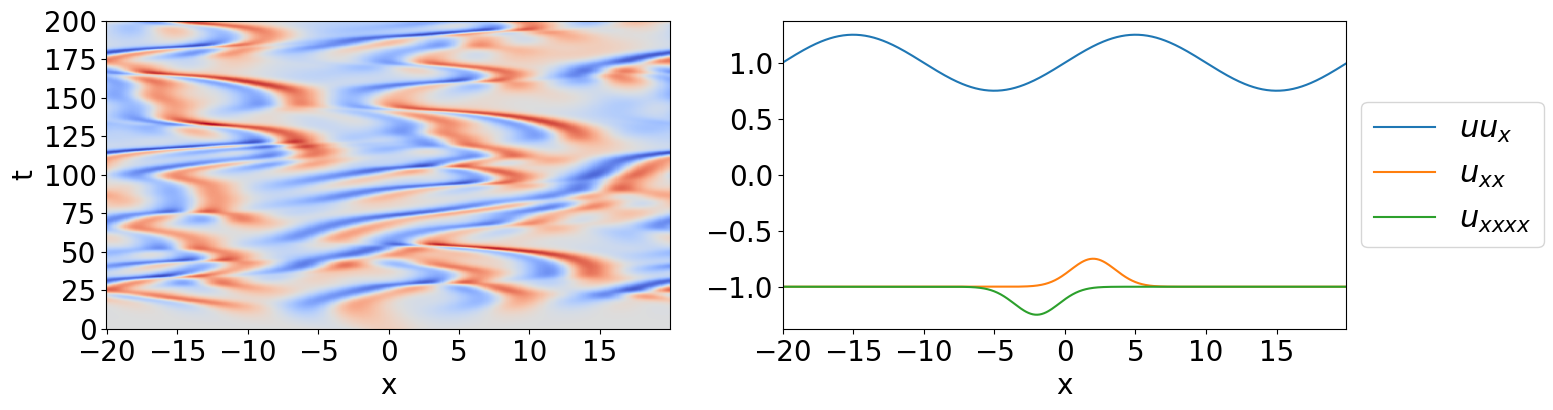

In [4]:
# Plot
fig = figure(figsize=(16, 4))
X, T = np.meshgrid(x, t)

subplot(1,2,1)
pcolor(X, T, u_full.T, cmap=cm.coolwarm)
xlabel('x', fontsize = fontsize)
ylabel('t', fontsize = fontsize)
xticks(fontsize = fontsize)
yticks(fontsize = fontsize)

uu_x_true = 1 + 0.25*np.sin(x*2*np.pi/L)
u_xx_true = -1 + 0.25*np.exp(-(x-2)**2/5)
u_4x_true = -1 - 0.25*np.exp(-(x+2)**2/5)

subplot(1,2,2)
plot(x, uu_x_true, label = r'$uu_x$')
plot(x, u_xx_true, label = r'$u_{xx}$')
plot(x, u_4x_true, label = r'$u_{xxxx}$')
xlim([x[0],x[-1]])

xticks(fontsize = fontsize)
yticks(fontsize = fontsize)
xlabel('x', fontsize = fontsize)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = fontsize+2)
# fig.tight_layout()

In [5]:
u = u_full[:,-m:]
t = t[-m:]

In [6]:
noise_lv = 0.01
np.random.seed(0)
u = u + noise_lv*0.01*std(u)*np.random.randn(n,m)

is_denoising = True
if is_denoising and noise_lv > 0:
    window_size = 15
    poly_order = 2
    u = savgol_filter(u, window_size, poly_order, axis=0)

alpha = 3e-4
diff_kwargs = {"kind": "kalman", "alpha": alpha}
Ut, Theta, Ut_grouped, Theta_grouped, rhs_des = construct_group_linear_system(u, x, t, 
                                                                              diff_kwargs, 
                                                                              include_bias=False)

In [7]:
# Theta_grouped = np.array([real(Theta[n*np.arange(m)+j,:]) for j in range(n)])
# Ut_grouped = np.array([real(Ut[n*np.arange(m)+j]) for j in range(n)])
fft_percent = 90
fft_Theta_grouped = np.array([remove_f(fft(Theta_grouped[:, :, k]), fft_percent) 
                              for k in range(Theta_grouped.shape[-1])])
fft_Theta_grouped = np.moveaxis(fft_Theta_grouped, 0, -1)
fft_Ut_grouped = remove_f(fft(Ut_grouped[:, :, 0]), fft_percent)
fft_Ut_grouped = np.expand_dims(fft_Ut_grouped, -1)

In [8]:
# Solve and plot
Xi,Tol,Losses = TrainSGTRidge(Theta_grouped, Ut_grouped)
xi = Xi[np.argmin(Losses)]

4 u_xx
5 u_xxx
6 u_xxxx
7 uu_x


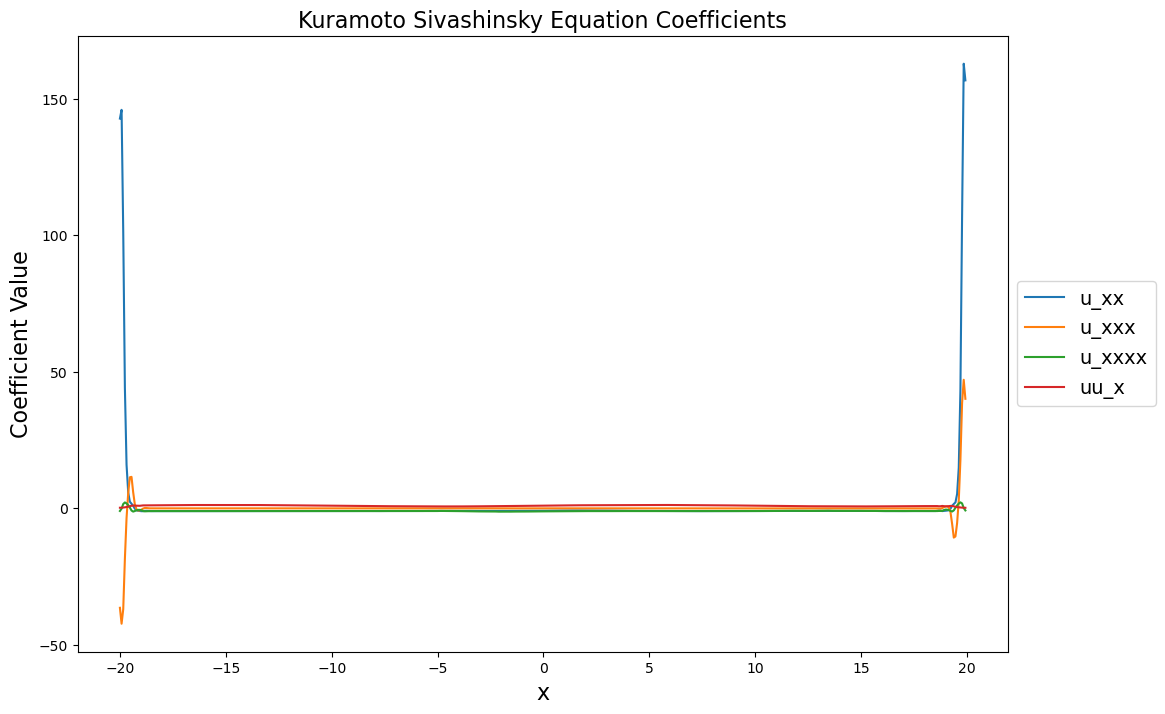

In [9]:
pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi.shape[0]): 
    if np.linalg.norm(xi[j,:]) > 10**-10:
        print(j, rhs_des[j])
        plot(x, xi[j,:], label = rhs_des[j])
                
title('Kuramoto Sivashinsky Equation Coefficients', fontsize = 16)
xlabel('x', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)

# mse_clean_sgtr = Norm(xi-xi_true[:,wx:-wx])**2/(m*len(rhs_des))
# print('MSE: ', mse_clean_sgtr)

In [10]:
candidates = set()
max_complexity = 10 # X_weak.shape[-1]

normalized_Theta_grouped, normalized_Ut_grouped = normalize_groups(Theta_grouped, 
                                                                   Ut_grouped, 
                                                                   2)

counter = {0}; i = 0
max_counter = 30
while True:
    bs_i = solvel0(normalized_Theta_grouped[i], 
                   normalized_Ut_grouped[i], 
                   max_complexity=max_complexity, 
                   miosr=True, refine=True, verbose=False)
    
#     bs_i = best_subset_all_solutions(normalized_Theta_grouped[i], 
#                                      normalized_Ut_grouped[i], 
#                                      sparsity=max_complexity, 
#                                      refine=True)[1]
    
#     bs_i = abess_all_solutions(normalized_Theta_grouped[i], 
#                                      normalized_Ut_grouped[i], 
#                                      sparsity=max_complexity, 
#                                      refine=True)[1]
    
    bs_i = list(map(tuple, bs_i))
    candidates = candidates.union(bs_i)
    
    if len(counter) == max_counter: break
        
    print(len(counter))
    i = np.random.choice(len(Theta_grouped))
    while i in counter:
        i = np.random.choice(len(Theta_grouped))
    counter.add(i)

candidates

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-04
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


{(0, 1, 2, 4, 6, 7, 9, 10, 16),
 (0, 1, 3, 4, 5, 6, 7, 8, 9, 13),
 (0, 1, 3, 4, 5, 6, 7, 9, 12, 15, 18),
 (0, 1, 3, 4, 5, 7, 9),
 (0, 1, 3, 4, 5, 7, 9, 10),
 (0, 1, 3, 4, 5, 7, 9, 10, 16),
 (0, 1, 3, 4, 5, 7, 9, 10, 16, 18),
 (0, 1, 3, 6, 7),
 (0, 1, 3, 6, 7, 9),
 (0, 1, 4, 5, 6, 7, 8, 13, 15, 17),
 (0, 1, 4, 5, 6, 7, 8, 13, 17),
 (0, 1, 4, 6, 7, 9),
 (0, 1, 4, 6, 7, 9, 10, 11, 15, 16),
 (0, 1, 4, 6, 7, 9, 10, 15, 16),
 (0, 1, 4, 6, 7, 9, 15, 16),
 (0, 1, 4, 6, 7, 9, 16),
 (0, 2, 3, 4, 6, 7, 12, 13, 15, 17),
 (0, 2, 4, 5, 6, 7, 9),
 (0, 2, 4, 5, 6, 7, 12, 15, 17),
 (0, 2, 4, 6, 7, 9),
 (0, 2, 4, 6, 7, 9, 10, 11, 16, 18),
 (0, 3, 4, 5, 6, 7, 9, 10, 15, 17),
 (0, 3, 4, 5, 6, 7, 9, 12, 15, 18),
 (0, 3, 4, 6, 7, 9, 10, 15, 17),
 (0, 4, 6, 7, 9),
 (0, 4, 6, 7, 9, 10, 11, 16),
 (0, 4, 6, 7, 9, 10, 11, 16, 18),
 (0, 4, 6, 7, 9, 11, 12),
 (0, 4, 6, 7, 9, 11, 12, 14),
 (0, 4, 6, 7, 9, 13),
 (0, 4, 6, 7, 9, 16),
 (1, 2, 3, 4, 6, 7, 8, 13, 16, 18),
 (1, 2, 4, 6, 7, 8, 15, 16, 17, 18),
 (1, 2, 4, 

In [11]:
lam = 0
for j in range(len(Ut_grouped)):
    est_xi = Ridge(alpha=0, fit_intercept=False).fit(Theta_grouped[j], Ut_grouped[j]).coef_.reshape(-1, 1)
    difference = Ut_grouped[j] - Theta_grouped[j].dot(est_xi)
    lam += (np.linalg.norm(difference, 2)**2)/(np.linalg.norm(est_xi, 2)**2)
lam /= len(Ut_grouped)
print("lam:", lam)

track = {}
for indices in tqdm(candidates):
    com = len(indices)
    rss = 0
    for j in range(len(Ut_grouped)):
        est_xi = Ridge(alpha=lam, fit_intercept=False).fit(Theta_grouped[j][:, indices], Ut_grouped[j]).coef_.reshape(-1, 1)
        difference = fft_Ut_grouped[j] - fft_Theta_grouped[j][:, indices].dot(est_xi)
        rss += np.linalg.norm(difference, 2)**2 + lam*np.linalg.norm(est_xi, 2)**2
    if com not in track or track[com][1] > rss:
        track[com] = indices, rss

candidates = set([e[0] for e in list(track.values())])
candidates

lam: 0.31935196666871957


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 181/181 [01:11<00:00,  2.54it/s]


{(0, 1, 3, 4, 5, 6, 7, 9, 12, 15, 18),
 (0, 3, 4, 6, 7, 9, 10, 15, 17),
 (1, 2, 3, 4, 6, 7, 8, 13, 16, 18),
 (2, 4, 6, 7, 10, 14, 15, 18),
 (3, 4, 6, 7),
 (3, 4, 6, 7, 8, 9, 10),
 (3, 4, 6, 7, 9, 14),
 (3, 4, 6, 7, 14),
 (4, 6, 7),
 (6, 7),
 (7,)}

aic: 11 3
bic: 11 3


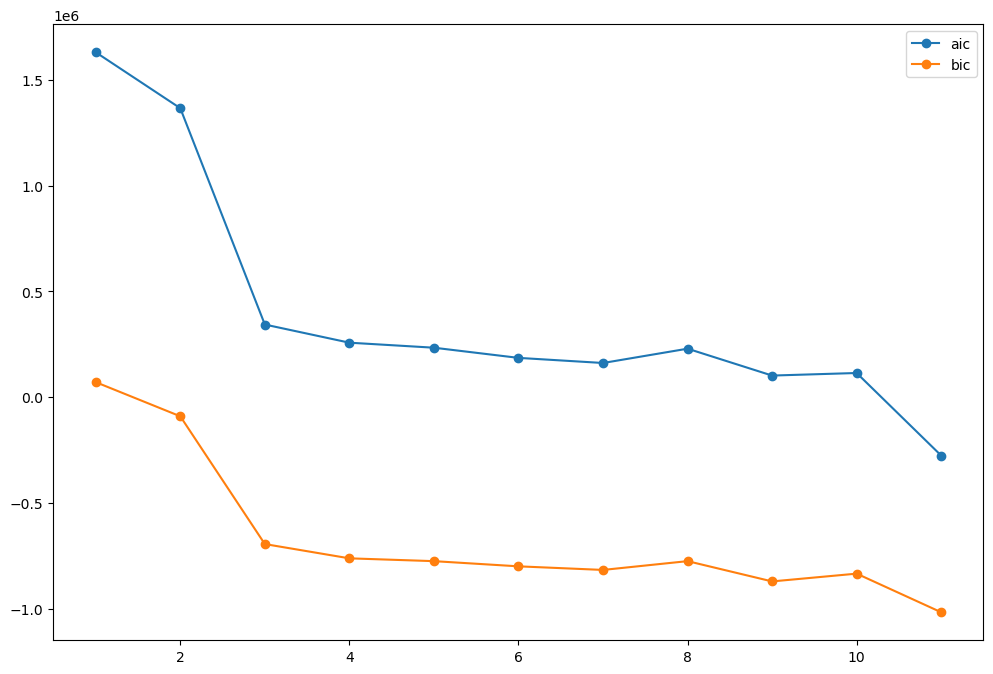

In [12]:
time_integrator = lambda _: _
time_integrator = partial(trapz, axis=0)
# psd = lambda _: np.expand_dims(power_spectral_density(_[:, :, 0]), -1)
psd = partial(power_spectral_density, axis=1)
time_integrator = compose(time_integrator, psd)
ic_scores = {}
for indices in candidates:
    est_xi = np.zeros((Theta_grouped[0].shape[-1], len(Ut_grouped)))
    for j in range(len(Theta_grouped)):
        est_xi[indices, j:j+1] = np.linalg.lstsq(Theta_grouped[j][:, indices], Ut_grouped[j], rcond=None)[0]
        
    # aic = PDE_FIND_Loss(Theta_grouped, Ut_grouped, est_xi)
    Ut_grouped_est = estimate_Ut_grouped_est(Theta_grouped, est_xi)
    rss = rss_group(Ut_grouped_est, Ut_grouped, time_integrator)
    N = np.prod(Ut_grouped.shape); k = len(np.where(np.linalg.norm(est_xi, axis=-1)>0)[0])
    aic = N*np.log(rss/N+1e-5) + 2*k+(2*k**2+2*k)/(N-k-1)
    
    bic = BIC_Loss(Theta_grouped, Ut_grouped, est_xi)
    
    if len(indices) not in ic_scores: ic_scores[len(indices)] = (aic, bic, indices)
    elif aic < ic_scores[len(indices)][0]: ic_scores[len(indices)] = (aic, bic, indices)

com_ics = sorted([(len(e[2]), e[0], e[1]) for e in list(ic_scores.values())])
complexities = [e[0] for e in com_ics]
aics = [e[1] for e in com_ics]
bics = [e[2] for e in com_ics]

print("aic:", complexities[np.argmin(aics)], find_corner(complexities, aics))
print("bic:", complexities[np.argmin(bics)], find_corner(complexities, bics))
plt.plot(complexities, aics, '-o', label='aic')
plt.plot(complexities, bics, '-o', label='bic'); plt.legend(); plt.show()

In [13]:
best_subsets = {}
for indices in candidates:
    est_xi = []
    uncert = 0.0
    rss = 0.0
    for j in trange(0, len(Theta_grouped), 1):        
        # model = Ridge(alpha=lam, fit_intercept=False)
        model = BayesianRidge(fit_intercept=False)
        model.fit(Theta_grouped[j][:, indices], Ut_grouped[j].flatten())
        post_prediction = (fft_Theta_grouped[j][:, indices]@model.coef_).reshape(-1, 1)
        rss = rss + np.linalg.norm(fft_Ut_grouped[j] - post_prediction, 'fro')**2
        
        coeff = model.coef_.reshape(-1, 1)
        uncert = uncert + np.sqrt(np.diag(model.sigma_)).sum()/abs(model.coef_).sum()
        est_xi.append(coeff)
        
    if len(indices) not in best_subsets: best_subsets[len(indices)] = (rss, uncert, indices)
    elif rss < best_subsets[len(indices)][0]: best_subsets[len(indices)] = (rss, uncert, indices)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:00<00:00, 750.27it/s]


In [14]:
complexities = sorted(best_subsets.keys())

min_uncert = np.min([best_subsets[com][1] for com in best_subsets])
uncertainties = []
for com in complexities:
    _, uncert, _ = best_subsets[com]
    uncert = uncert/min_uncert
    uncertainties.append(uncert)
uncertainties = np.array(uncertainties)

psd_method = 'periodogram' # periodogram, welch
nfft = max(fft_Ut_grouped[:, :, 0].shape)
nfft = None
ground_periogram = power_spectral_density(ifft(fft_Ut_grouped[:, :, 0]), nfft=nfft, method=psd_method)
nobs = np.prod(ground_periogram.shape)
epsilons = []
for com in complexities:
    est_xi = np.zeros((fft_Theta_grouped[0].shape[-1], len(fft_Ut_grouped)))
    eff_indices = best_subsets[com][-1]
    for j in range(len(Theta_grouped)):
        est_xi[eff_indices, j:j+1] = BayesianRidge(fit_intercept=False).fit(Theta_grouped[j][:, eff_indices], 
                                                                            Ut_grouped[j].flatten()).coef_.reshape(-1, 1)
#         est_xi[eff_indices, j:j+1] = np.linalg.lstsq(Theta_grouped[j][:, eff_indices], 
#                                                      Ut_grouped[j], 
#                                                      rcond=None)[0]
    pred_group = ifft(prediction_group(fft_Theta_grouped, est_xi))
    pred_periogram = power_spectral_density(pred_group, nfft=nfft, method=psd_method)

    res = np.vstack([ground_periogram[j]-pred_periogram[j] for j in range(len(Theta_grouped))])
    rss = np.linalg.norm(res, ord='fro')**2
    epsilons.append(2*np.pi*rss/nobs)
epsilon = max(epsilons)
epsilon

57.30985004604906

3


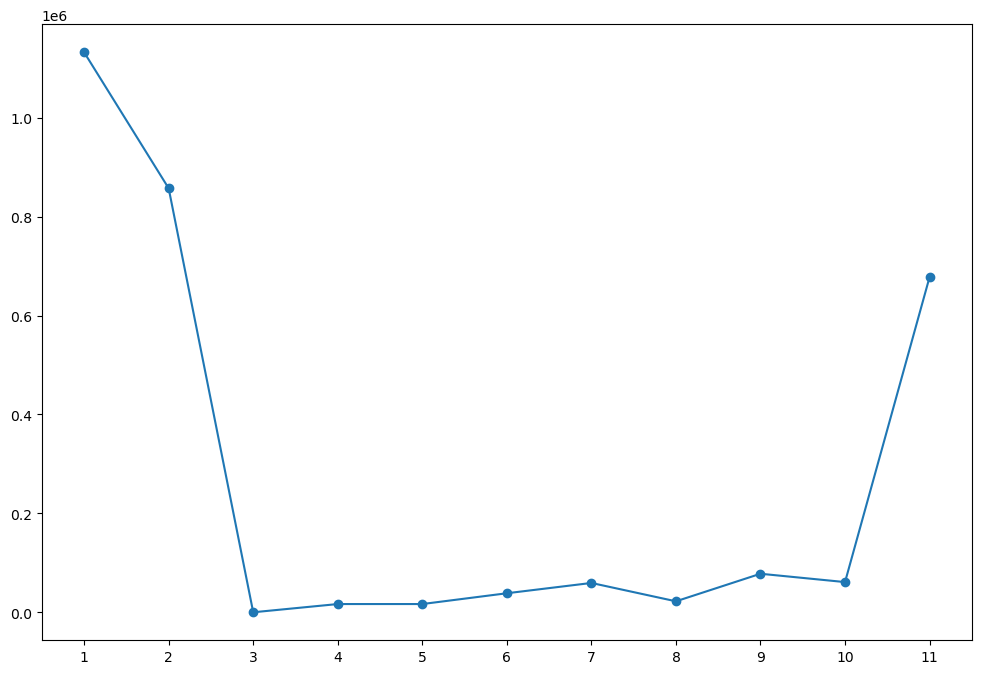

In [15]:
epsilon = 1e-5
time_integrator = lambda _: _
time_integrator = partial(trapz, axis=0)
ics = []
rss_list = []
varying_bics = []
for com in complexities:
    vbics = []
    est_xi = np.zeros((fft_Theta_grouped[0].shape[-1], len(fft_Ut_grouped)))
    eff_indices = best_subsets[com][-1]
    for j in range(len(Theta_grouped)):
        est_xi[eff_indices, j:j+1] = BayesianRidge(fit_intercept=False).fit(Theta_grouped[j][:, eff_indices], 
                                                                            Ut_grouped[j].flatten()).coef_.reshape(-1, 1)
#         est_xi[eff_indices, j:j+1] = np.linalg.lstsq(Theta_grouped[j][:, eff_indices], 
#                                                      Ut_grouped[j], 
#                                                      rcond=None)[0]
        post_prediction = fft_Theta_grouped[j][:, eff_indices]@(est_xi[eff_indices, j:j+1])
        post_prediction = power_spectral_density(ifft(post_prediction.flatten()), method=psd_method)
        ground = power_spectral_density(ifft(fft_Ut_grouped[j].flatten()), method=psd_method)
        rss = np.linalg.norm(ground - post_prediction, 2)**2
        # vbics.append(rss2bic(rss, com+uncertainties[com-1], len(post_prediction), epsilon))
        vbics.append(rss2bic(rss, com, len(post_prediction), epsilon))
        
    pred_group = ifft(prediction_group(fft_Theta_grouped, est_xi))
    pred_periogram = power_spectral_density(pred_group, nfft=nfft, method=psd_method)
    diff_periogram = time_integrator(ground_periogram)-time_integrator(pred_periogram)
    res = np.vstack([diff_periogram[j] for j in range(len(Theta_grouped))])
    rss = np.linalg.norm(res, ord='fro')**2
    ics.append(nobs*np.log(2*np.pi*rss/nobs+epsilon) + np.log(nobs)*com)
    rss_list.append(rss)
    varying_bics.append(vbics)
    
varying_bics = np.array(varying_bics)
varying_bics_ranking = np.argsort(varying_bics.sum(axis=-1))
print(np.argmin(ics)+1)
plt.plot(complexities, ics-min(ics), '-o')
plt.xticks(complexities)
plt.show()

In [16]:
verbose = True
tau = 3
b_bics = []
lower_bounds = []
for com in complexities:
    _, _, indices = best_subsets[com]
    rss = rss_list[com-1]
    assert com == len(indices)
    lower_bound = 2*np.abs(ssr2llf(rss, nobs))/np.log(nobs)-com
    lower_bounds.append(lower_bound)
    b_bics.append(rss2bic(rss, com, nobs, epsilon))
assert np.allclose(np.array(b_bics), np.array(ics))
print(find_corner(complexities, b_bics))
    
last_lam = np.log10(max(max(lower_bounds/uncertainties), 1e-8))
delta = last_lam/tau
now_lam = last_lam-delta
last_ubic = UBIC(b_bics, uncertainties, nobs, hyp=10**last_lam)
last_bc = np.argmin(last_ubic)

thres = 1e-4
percent = 75 # 75 # 90 (เพราะไม่เอา complexity = 1)
b_bics = np.array(b_bics)
complexities = np.array(complexities)
d_complexities = complexities[decreasing_values_indices(b_bics)]
d_bics = b_bics[decreasing_values_indices(b_bics)]
thres = max(thres, np.percentile(np.abs(np.diff(d_bics)/(np.diff(d_complexities)*d_bics[:-1])), percent))
pcut = 0.01

while now_lam >= 0:
    now_ubic = UBIC(b_bics, uncertainties, nobs, hyp=10**now_lam)
    now_bc = np.argmin(now_ubic)

    diff_com = now_bc-last_bc
    diff_bic = b_bics[now_bc]-b_bics[last_bc]
    diff_vbic = (varying_bics[now_bc]-varying_bics[last_bc])
    
    diff_vbic_adj = np.array([-np.inf for _ in range(1000)])
    adj_bc = varying_bics_ranking[varying_bics_ranking<now_bc]
    if len(adj_bc) > 0:
        adj_bc = adj_bc[0]
        diff_vbic_adj = varying_bics[now_bc]-varying_bics[adj_bc]

    imp = np.nan
    pvalue_pos = pvalue_neg = pvalue_adj = np.nan
    if np.abs(diff_com) > 0:
        # imp < thres <--> pvalue > pcut
        imp = abs(diff_bic/(b_bics[last_bc]*diff_com))
        pvalue_pos = wilcoxon(diff_vbic, alternative='less').pvalue
        pvalue_neg = wilcoxon(-diff_vbic, alternative='less').pvalue
        pvalue_adj = wilcoxon(diff_vbic_adj, alternative='less').pvalue

    # new version using wilcoxon test
    if verbose:
        print(last_bc, '--->', adj_bc, '--->', now_bc, 'p-value:', 
              np.nan_to_num(pvalue_pos, nan=np.inf), 
              np.nan_to_num(pvalue_neg, nan=np.inf), 
              np.nan_to_num(pvalue_adj, nan=np.inf))
    if (diff_com > 0 and (diff_bic > 0 or pvalue_pos > pcut or pvalue_adj > pcut)) or \
        (diff_com < 0 and diff_bic > 0 and pvalue_pos > pcut and pvalue_neg <= pcut):
        break
        
    ### old version using threshold ###
#     if verbose:
#         print(last_bc, '--->', now_bc, np.nan_to_num(imp, nan=np.inf))
#     if (diff_com > 0 and (diff_bic > 0 or imp < thres)) or \
#         (diff_com < 0 and diff_bic > 0 and imp > thres):
#         break

    last_lam = now_lam
    now_lam = last_lam-delta
    last_ubic = now_ubic
    last_bc = now_bc
    now_lam = round(now_lam, 8)

last_lam = abs(round(last_lam, 8))
best_indices = best_subsets[complexities[last_bc]][-1]; print(best_indices, "selected")
# 2 ---> 4 ---> 8 8.230679206001151e-41 1.0 0.997720336917782
last_lam, last_ubic, last_bc

3
3 ---> 1 ---> 2 p-value: 0.005486768008091043 0.994513231991909 4.6116395148654357e-38
2 ---> 1 ---> 2 p-value: inf inf inf
2 ---> 1 ---> 2 p-value: inf inf inf
(4, 6, 7) selected


(0.0,
 array([1928287.99911252, 1653155.19199804,  795652.48207849,
         812298.12489088,  812309.66448927,  834124.01680611,
         854963.71781216,  817839.94716037,  873578.03684089,
         856725.52324641, 1473567.51706798]),
 2)

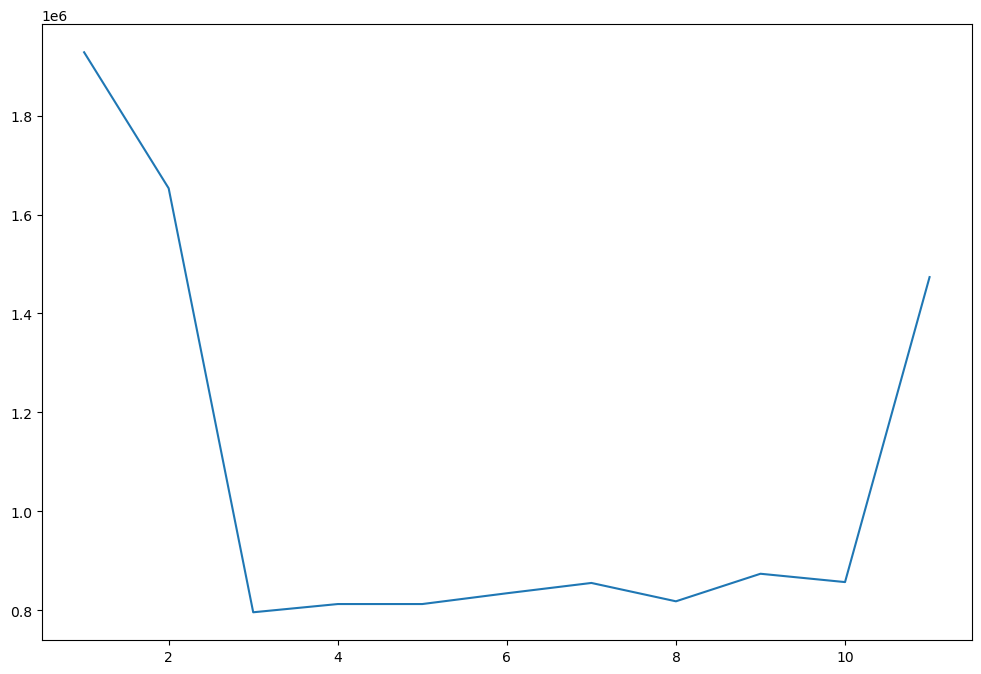

In [17]:
plt.plot(complexities, last_ubic); plt.show()